# SIECI NEURONOWE, PROJEKT 1
#### Autorzy: Mikołaj Rzepiński, Damian Wysokiński

#### Siec dla regresji

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d___%H-%M-%S")

In [3]:
include_bias = True # True lub False
error_type = 'MSE'  #'MSE' lub 'MAE' 

In [4]:

#'data.activation.train.1000.csv'
#'data.cube.train.100.csv'
# 'data.linear.train.500.csv'
# 'data.multimodal.train.500.csv'
# 'data.square.train.500.csv'
regression_train_file = 'regression\data.square.train.500.csv' 
regression_df = pd.read_csv(regression_train_file)

    
# ''
#'data.activation.test.1000.csv'
#'data.cube.test.100.csv'
# 'data.linear.test.500.csv'
# 'data.multimodal.test.500.csv'
# 'data.square.train.500.csv'

regression_test_file = 'regression\data.square.train.500.csv'
regression_test_df = pd.read_csv(regression_test_file)
    

In [5]:
x_train = np.array(regression_df['x']).reshape(1,-1)
y_train = np.array(regression_df['y']).reshape(1,-1)
    
x_test = np.array(regression_test_df['x']).reshape(1,-1)
y_test = np.array(regression_test_df['y']).reshape(1,-1)

In [6]:
n_nodes_input_layer = 1
output_layer_activation_function = "linear"

input_layer = [
    {
        "n_nodes": n_nodes_input_layer,
        "activation_function": None
    },
]

hidden_layers = [
    {
        "n_nodes": 12,
        "activation_function": "relu"
    },
    #{
     #   "n_nodes": 12,
     #   "activation_function": "relu"
    #},
    #{
     #   "n_nodes": 12,
     #   "activation_function": "relu"
    #}#,
    #{
    #   "n_nodes": 6,
    #    "activation_function": "relu"
    #}   
]


n_nodes_output_layer = 1
    
output_layer = [
    {
        "n_nodes": n_nodes_output_layer,
        "activation_function": output_layer_activation_function
    }, ]

layers = input_layer + hidden_layers + output_layer
layers

[{'n_nodes': 1, 'activation_function': None},
 {'n_nodes': 12, 'activation_function': 'relu'},
 {'n_nodes': 1, 'activation_function': 'linear'}]

In [7]:
def initialize_parameters(x_train, layers):
    
    #np.random.seed(42) # jeśli chcemy za każdym razem te same wyniki
    
    n_features = x_train.shape[0]
    n_examples = x_train.shape[1]
    
    n_layers = len(layers) 
    
    parameters = {}
    activation_values = {}
    
    
    activation_values['0'] = x_train 
    
    for n_layer in range(1,n_layers):

        parameters["W" + str(n_layer)] = np.random.randn(layers[n_layer]["n_nodes"], layers[n_layer-1]["n_nodes"]) * 0.01 #wczesniej 0.01
        if(include_bias):
            parameters["b" + str(n_layer)] = np.zeros((layers[n_layer]["n_nodes"],1))

    return parameters, activation_values

In [8]:
def z_forward(parameters, activation_values, z_values, index_of_layer):
    if(include_bias):
        z_values[str(index_of_layer)] = np.dot(parameters['W' + str(index_of_layer)],
                                               activation_values[str(index_of_layer -1)]) + parameters['b' + str(index_of_layer)]
    else:
        z_values[str(index_of_layer)] = np.dot(parameters['W' + str(index_of_layer)],
                                               activation_values[str(index_of_layer -1)])

#### activation functions:

In [9]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def relu(x):
    return np.maximum(0,x)

def leaky_relu(x):
    return np.maximum(0.1*x, x)

def linear(x):
    return x

In [10]:
def forward_with_activation(z, activation_values, activation_function, index):
    if(activation_function == 'linear'):
        activation_values[str(index)] = linear(z)
        
    elif(activation_function == 'sigmoid'):
        activation_values[str(index)] = sigmoid(z)
        
    elif(activation_function == 'relu'):
        activation_values[str(index)] = relu(z)
        
    elif(activation_function == 'leaky_relu'):
        activation_values[str(index)] = leaky_relu(z)
        
    elif(activation_function == 'softmax'):
        activation_values[str(index)] = softmax(z)

In [11]:
def get_activation_functions(layers):
    activation_functions = {}
    for idx, layer in enumerate(layers):
        activation_functions[str(idx)] = layer['activation_function']
    
    return activation_functions
    

In [12]:
def all_layers_forward_propagation(parameters, activation_values, activation_functions, z_values, no_of_layers):
    for idx in range(1, no_of_layers):
        z_forward(parameters, activation_values, z_values,  idx)
        forward_with_activation(z_values[str(idx)], activation_values, activation_functions[str(idx)], idx)
        
    
    return activation_values[str(no_of_layers - 1)]

In [13]:
def linear_derivative():
    return 1

def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def leaky_relu_derivative(x):
    x[x<=0] = 0.1
    x[x>0] = 1
    return x

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


In [14]:
def MAE_derivative(activation_value, y_true):
    
    diff = np.zeros(activation_value.shape)
    diff[activation_value >= y_true] = 1
    diff[activation_value < y_true] = -1
    
    return diff

In [15]:
def last_layer_back_propagation(gradients, activation_values, activation_functions, z_values, index, y_true):
    m = y_true.shape[1]
    
    if(activation_functions[str(index)] == 'linear'):
        activation_function_derivative = linear_derivative()
        
    elif(activation_functions[str(index)] == 'relu'):
        activation_function_derivative = relu_derivative(activation_values[str(index)])
        
    elif(activation_functions[str(index)] == 'leaky_relu'):
        activation_function_derivative = leaky_relu_derivative(activation_values[str(index)])
    
    if(error_type == 'MSE'):
        gradients['dZ' + str(index)] = (activation_values[str(index)] - y_true) * activation_function_derivative 

    elif(error_type == 'MAE'): 
        gradients['dZ' + str(index)] = MAE_derivative(activation_values[str(index)], y_true) * activation_function_derivative
        
    gradients['dW' + str(index)] = 1/m * np.dot(gradients['dZ'+str(index)], activation_values[str(index - 1)].T)
    if(include_bias):
        gradients['db' + str(index)] = 1/m * np.sum(gradients['dZ'+str(index)], axis=1, keepdims=True)

In [16]:
def mid_layer_back_propagation(parameters, gradients, activation_values, activation_functions, z_values, index, y_true):  
    m = y_true.shape[1]
    
    if(activation_functions[str(index)] == 'linear'):
        activation_function_derivative = linear_derivative()
        
    elif(activation_functions[str(index)] == 'relu'):
        activation_function_derivative = relu_derivative(activation_values[str(index)])
        
    elif(activation_functions[str(index)] == 'leaky_relu'):
        
        activation_function_derivative = leaky_relu_derivative(activation_values[str(index)])
    
    elif(activation_functions[str(index)] == 'sigmoid'):
        activation_function_derivative = sigmoid_derivative(activation_values[str(index)])
        
    
    if(error_type == 'MSE' or error_type == 'MAE'):    
        gradients['dZ'+str(index)] = np.dot(parameters['W'+str(index + 1)].T, gradients['dZ'+str(index + 1)])  * activation_function_derivative#relu_derivative(activation_values[str(index)])
    
    gradients['dW'+str(index)] = 1/m * np.dot(gradients['dZ'+str(index)], activation_values[str(index - 1)].T)
    if(include_bias):
        gradients['db'+str(index)] = 1/m * np.sum(gradients['dZ'+str(index)], axis=1, keepdims=True)

   

In [17]:
def all_layers_back_propagation(y_true, parameters, gradients, activation_values, activation_functions, z_values, no_of_layers):
    
    m = y_true.shape[1]
    for i in reversed(range(1,no_of_layers)):
        
        if(i == no_of_layers - 1):            
            last_layer_back_propagation(gradients, activation_values, activation_functions,z_values,i,y_true)
        
        else:
            mid_layer_back_propagation(parameters,gradients,activation_values,activation_functions,z_values,i,y_true)
            

In [18]:
def calculate_error(y_hat, y_true):
    
    n_examples = y_hat.shape[1]
    
    if(error_type == 'MSE'):
        return 1/n_examples * np.sum((y_true - y_hat)**2)
    elif(error_type == 'MAE'):
        return 1/n_examples * np.sum(np.abs(y_true - y_hat))

In [19]:
def update_parameters(parameters, gradients, no_of_layers, learning_rate = 0.001):#0.001
    
    for i in range(1,no_of_layers):
        parameters['W' + str(i)] -= learning_rate * gradients['dW'+str(i)]
        if(include_bias):
            parameters['b' + str(i)] -= learning_rate * gradients['db' + str(i)]

In [20]:
def neural_network_regression(x_train, y_train, layers, no_of_iterations = 5000):
    parameters , activation_values = initialize_parameters(x_train, layers)
    
    g_values = {}
    g_prime_values = {}
    activation_functions = get_activation_functions(layers) # {'0': 'relu', '1': 'sigmoid', ...}
    z_values = {}
    gradients = {}
    losses = []
    
    no_of_layers = len(layers)
    
    for i in range(1,no_of_iterations):
        
        all_layers_forward_propagation(parameters, activation_values, activation_functions, z_values, no_of_layers)
        
        losses.append(calculate_error(activation_values[str(no_of_layers - 1)], y_train))
        
        all_layers_back_propagation(y_train,parameters,gradients,activation_values,activation_functions,z_values,no_of_layers)
        update_parameters(parameters,gradients,no_of_layers)
    
    if(error_type == 'MSE'):
        print('ostatni blad po pierwiastkowaniu: ', np.sqrt(losses[-1]))
    elif(error_type == 'MAE'):
        print('ostatni blad MAE: ', losses[-1])
    
    plt.plot(losses[:])
    plt.title(f'błąd uczenia {error_type}   {regression_train_file[11:-4]}')
    plt.xlabel('nr kroku uczenia')
    plt.ylabel('błąd')
    plt.savefig(f'wykresy/{now}_error_{regression_train_file[11:-4]}_{error_type}_{len(hidden_layers)}_hidden_layers.jpg')
    plt.show()
    
    return parameters
    

ostatni blad po pierwiastkowaniu:  71.61250409635335


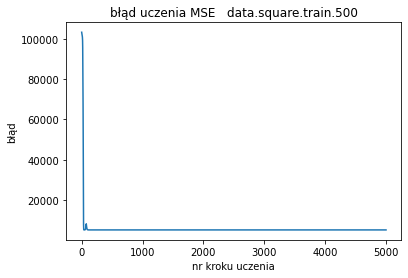

In [21]:
new_parameters = neural_network_regression(x_train, y_train, layers, no_of_iterations = 5000) 

In [22]:
new_parameters #parametry nauczonej sieci:

{'W1': array([[-8.47875324e-01],
        [-1.53693047e-01],
        [-1.03279899e-01],
        [-4.08096161e-04],
        [-4.18876576e-05],
        [-5.61440206e-03],
        [-7.29995654e-03],
        [-3.01165041e-01],
        [-3.66544881e-01],
        [-1.87591509e+00],
        [-9.13105583e-01],
        [-1.20360376e+00]]),
 'b1': array([[ 6.81539215e+00],
        [ 1.09618938e+00],
        [ 7.36875158e-01],
        [-4.50954703e-03],
        [-1.05171080e-03],
        [ 3.97653716e-02],
        [ 1.67570998e-01],
        [ 2.14981684e+00],
        [ 3.03124663e+00],
        [ 1.43330751e+01],
        [ 6.98172898e+00],
        [ 9.19493093e+00]]),
 'W2': array([[-5.98668316e+00, -9.71520735e-01, -6.53856420e-01,
          1.18313822e-02,  5.16469590e-03, -3.48225184e-02,
         -1.46483275e-01, -1.90880402e+00, -2.66172032e+00,
         -1.26009514e+01, -6.13789955e+00, -8.08376768e+00]]),
 'b2': array([[-7.64430105]])}

In [23]:
def predict_regression(parameters, x_test, layers):
    activation_functions = get_activation_functions(layers)
    activation_values = {'0': x_test}
    z_values = {}
    
    predicted_values_regression = all_layers_forward_propagation(parameters,activation_values,activation_functions,
                                                     z_values, no_of_layers=len(layers))
    return predicted_values_regression

wykres działania sieci (regresji na nowych danych)
regression\data.square.train.500.csv


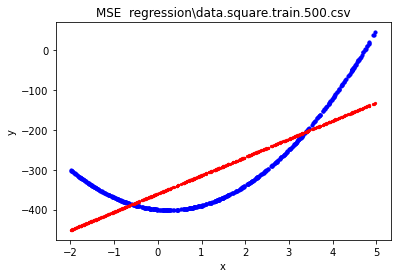

wykres działania sieci (regresji na danych, na których sieć była uczona)
regression\data.square.train.500.csv


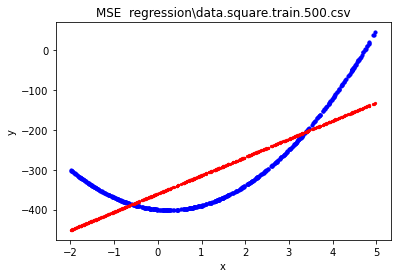

In [24]:
y_predicted_values_regression = predict_regression(new_parameters, x_test, layers)


#na danych testowych
print("wykres działania sieci (regresji na nowych danych)")
print(regression_test_file)
plt.scatter(*x_test,*y_test, color='blue', s=10)
plt.scatter(*x_test,*y_predicted_values_regression, color='red', s=5)

plt.title(error_type + '  ' + regression_test_file)
plt.xlabel('x')
plt.ylabel('y')

plt.savefig(f'wykresy/{now}_{regression_test_file[11:-4]}_{error_type}__{len(hidden_layers)}_hidden_layers.jpg')
plt.show()



#na danych treningowych
print("wykres działania sieci (regresji na danych, na których sieć była uczona)")
print(regression_train_file)
y_train_predicted = predict_regression(new_parameters, x_train, layers)
plt.scatter(*x_train,*y_train, color='blue', s=10)
plt.scatter(*x_train,*y_train_predicted, color='red', s=5)

plt.title(error_type + '  ' + regression_train_file)
plt.xlabel('x')
plt.ylabel('y')    
plt.savefig(f'wykresy/{now}_{regression_train_file[11:-4]}_{error_type}__{len(hidden_layers)}_hidden_layers.jpg')
plt.show()


Poniższy cell uruchamiać jeśli chcemy sprawdzić powtarzalność wyników sieci

ostatni blad po pierwiastkowaniu:  71.61250409635335


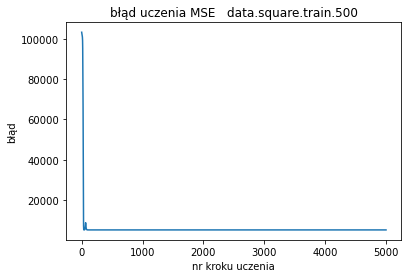

5128.350742950225
5128.350742950225
ostatni blad po pierwiastkowaniu:  18.478913882854965


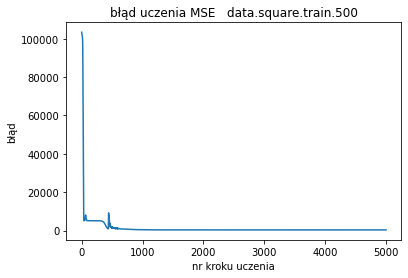

340.1701473716667
340.1701473716667
ostatni blad po pierwiastkowaniu:  40.20279298522952


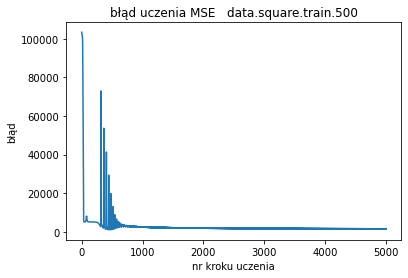

1531.4499833530492
1531.4499833530492
ostatni blad po pierwiastkowaniu:  71.61250409635335


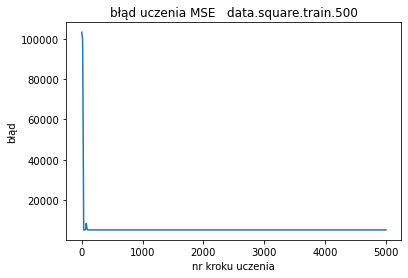

5128.350742950224
5128.350742950224
ostatni blad po pierwiastkowaniu:  40.07298758007574


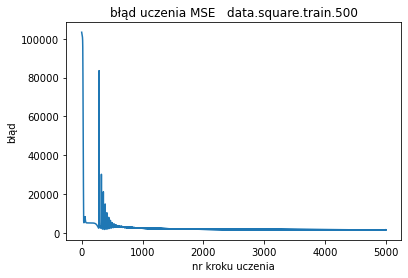

1522.2037494843216
1522.2037494843216
test errors [5128.350742950225, 340.1701473716667, 1531.4499833530492, 5128.350742950224, 1522.2037494843216]
srednia: 2730.1050732218973
odchylenie_std 2005.5300130836026
min 340.1701473716667
max 5128.350742950225
train_errors [5128.350742950225, 340.1701473716667, 1531.4499833530492, 5128.350742950224, 1522.2037494843216]
srednia: 2730.1050732218973
odchylenie_std 2005.5300130836026
min 340.1701473716667
max 5128.350742950225


In [25]:
test_errors = []
train_errors = []

for _ in range(5):
    new_parameters = neural_network_regression(x_train, y_train, layers, no_of_iterations = 5000)
    y_predicted_values_regression = predict_regression(new_parameters, x_test, layers) #testowe
    test_errors.append(calculate_error(y_predicted_values_regression,y_test))
    print(calculate_error(y_predicted_values_regression,y_test))
    
    y_predicted_train = predict_regression(new_parameters, x_train, layers)
    train_errors.append(calculate_error(y_predicted_train, y_train))
    print(calculate_error(y_predicted_train, y_train))
    

print('test errors', test_errors)
print('srednia:', np.mean(test_errors))
print('odchylenie_std', np.std(test_errors))
print('min', np.min(test_errors))
print('max', np.max(test_errors))
print('========')
print('train_errors', train_errors)
print('srednia:', np.mean(train_errors))
print('odchylenie_std', np.std(train_errors))
print('min', np.min(train_errors))
print('max', np.max(train_errors))